In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## BN原理

- `ICS(Internal Covariate Shift)`：因为每一层参数变化导致每一层输入分布发生变化，导致网络学习困难（需要更小的学习率以及更仔细的初始化，还存在饱和区域造成梯度消失的问题）
- `BN（Batch Normalization）`的提出就是为了减少ICS，使得网络可以更好的学习，同时起到加速训练的作用（原始论文），后来MIT的一篇2018年的论文通过四个对比实验说明了，BN的work跟ICS没啥关系，甚至可能会增大ICS；BN work的根本原因是使得优化地形更加平滑，而且其他的一些normalization技术也有类似的效果，有些甚至比BN还好
- `BN`使用对mini-batch简单归一化和线性变换来克服白化的缺点（计算量大，存在不可导，改变网络层本身的表达能力）
- 训练的时候：
    - $\mu_{\beta} = \frac{1}{m}\sum_{i=1}^m x_i$
    - $\sigma_{\beta} = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\beta})^2$
    - $x_i = \frac{x_i - \mu_{\beta}}{\sigma_{\beta}}$
    - $y_i = \gamma \hat x_i + \beta$，可学习的拉伸和偏移参数保留了不对$\hat x_i$做批量归一化的可能，此时只需要学到$\gamma \sqrt{\sigma_{\beta}^2 + \epsilon}$和$\beta=\mu_{\beta}$
- 推理的时候：
    - $E(x) = E_{\beta}[\mu_{\beta}], var(x) = \frac{m}{m-1}E_{\beta}[{\sigma^2_{\beta}}$]
- 由于BN和Dropout之间存在方差偏移，所以在同时使用Dropout和BN时，在推理过程中可能存在问题
    - 要不将Dropout放在所有的BN之后
    - 要不修改Dropout的公式
- 在训练的时候，batch_size不能设置太小，在测试的时候，理论上可以使用全部训练数据的方差和均值来计算，但是一般不能放所有的训练数据，因此一般采取移动平均来进行计算（在训练模式和测试模式下的训练结果是不一样的）
- 另外BN在计算全连接层和CNN层是有区别的，一般不用在RNN，因为RNN的输入序列长度不一样，造成方差和均值的统计困难

## BN的实现

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import sys
sys.path.append("../d2l_func/")
from sqdm import sqdm
from data_prepare import download_data_fashion_mnist, load_data_fashion_mnist
from model_train import train_experiment, train_pytorch, train_epoch

### BN的全连接层验证

In [4]:
a = torch.arange(12.).view(3, 4)
a

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

这里的mini-batch为3，实际上就是求每个神经元的均值，并且求方差的时候是求批的总体方差，而不是样本方差

In [5]:
# 往mini-batch的方向
mean = a.mean(dim=0, keepdim=True)
var = ((a - mean)**2).mean(dim=0, keepdim=True)
mean, var
# 假设gamma=1, beta=0
a_bn = (a - mean)/torch.sqrt(var + 1e-05)
a_bn

(tensor([[4., 5., 6., 7.]]), tensor([[10.6667, 10.6667, 10.6667, 10.6667]]))

tensor([[-1.2247, -1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247,  1.2247]])

In [6]:
# 使用pytorch来实现（无论是1d还是2d都需要传进特征数）
bn = nn.BatchNorm1d(4)
# gamma and beta
bn
bn.weight
bn.bias

# a after bn
bn(a)

BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)

tensor([[-1.2247, -1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247,  1.2247]],
       grad_fn=<NativeBatchNormBackward>)

### BN的卷积层验证

In [7]:
a = torch.arange(36.).view(2, 2, 3, 3)
a

tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]],


        [[[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]],

         [[27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]]]])

对卷积层做BN操作，实际上就是将每个特征图看成一个神经元，如果求均值和方差，最后在批上进行BN操作

In [8]:
# 先对哪个维度求均值其实没有什么影响（只要不对通道（维度1）求均值即可）
mean = a.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
var = ((a - mean)**2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
mean
var

a_bn = (a - mean)/torch.sqrt(var + 1e-05)
a_bn

tensor([[[[13.]],

         [[22.]]]])

tensor([[[[87.6667]],

         [[87.6667]]]])

tensor([[[[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]],

         [[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]]],


        [[[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]],

         [[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]]]])

In [9]:
# 使用pytorch来实现(传入输入的通道数)
bn = nn.BatchNorm2d(2)
# the weight and bias in bn
bn
bn.weight
bn.bias

# a after bn
bn(a)

BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Parameter containing:
tensor([1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0.], requires_grad=True)

tensor([[[[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]],

         [[-1.3884, -1.2816, -1.1748],
          [-1.0680, -0.9612, -0.8544],
          [-0.7476, -0.6408, -0.5340]]],


        [[[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]],

         [[ 0.5340,  0.6408,  0.7476],
          [ 0.8544,  0.9612,  1.0680],
          [ 1.1748,  1.2816,  1.3884]]]], grad_fn=<NativeBatchNormBackward>)

### BN的个人实现

在pytorch实现BN时，有一个参数`momentum`，这个参数是用在求移动平均的

In [6]:
class BatchNorm(nn.Module):
    """
    function: the class of BatchNorm
    params num_features: In fc layer, the num_features stands for the number of features to the next layer,
                         In conv layer, the num_features stands for the the channels of output in the last layer.
    params num_dims: the num_dims stands for the shape of output in the last layer, the fc layer is 2,
                     the conv layer is 4
    """
    def __init__(self, num_features, num_dims, eps=1e-5, momentum=0.9):
        super(BatchNorm, self).__init__()
        assert num_dims in (2, 4)
        if num_dims == 2:
            # fc layer, num_features ---> the number of neural
            shape = (1, num_features)
        else:
            # conv layer, num_features ---> the number of channels
            shape = (1, num_features, 1, 1)
        
        # init gamma and beta
        # if not use nn.Parametes, it will be a constant parameters which can't learning
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.eps = eps
        self.momentum = momentum
        self.num_dims = num_dims
        self.mean, self.var, self.x_hat= None, None, None
        
        # moving mean and var in test
        self.moving_mean, self.moving_var = torch.zeros(shape), torch.zeros(shape)
        
        
    def batch_norm(self, x):
        # test mode
        if not self.training:
            self.x_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        else:
            assert self.num_dims in (2, 4)
            # fc layer
            if self.num_dims == 2:
                self.mean = x.mean(dim=0, keepdim=True)
                # population var in mini-batch
                self.var = ((x - self.mean)**2).mean(dim=0, keepdim=True)
            else:
                # conv layer
                self.mean = x.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
                self.var = ((x - self.mean)**2).mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            # update moving mean and var
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * self.mean
            self.moving_var = self.momentum * self.moving_var + (1 - self.momentum) * self.var

            self.x_hat = (x - self.mean) / torch.sqrt(self.var + self.eps)
            
        # bn
        return self.gamma * self.x_hat + self.beta
    
    
    def forward(self, x):
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
            
        output = self.batch_norm(x)
        return output

In [7]:
# lenet5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            BatchNorm(num_features=6, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            BatchNorm(num_features=16, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 120, 5),
            BatchNorm(num_features=120, num_dims=4),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            BatchNorm(num_features=84, num_dims=2),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        output = self.conv(x)
        output = output.view(output.shape[0], -1)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc 

In [15]:
params = {
    "epoch_num": 15,
    "lr": 0.01,
    "momentum": 0.9,
    "batch_size": 256,
    "num_workers": 16,
}

# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=params["momentum"])
# load data
mnist_train, mnist_test = download_data_fashion_mnist()
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=params["num_workers"])
test_iter = Data.DataLoader(mnist_test, len(mnist_test), num_workers=params["num_workers"], shuffle=True)
test_x, test_y = iter(test_iter).next()
test_x, test_y = test_x.cuda(), test_y.cuda()

# training bar
process_bar = sqdm()

for epoch in range(params["epoch_num"]):
    train_mean_loss, train_mean_score = 0., 0.
    test_mean_loss, test_mean_score = 0., 0.
    print(f"Epoch [{epoch+1}/{params['epoch_num']}]")
    for x, y in train_iter:
        x = x.cuda()
        y = y.cuda()
        # training
        _ = model.train()
        train_pred = model(x)
        train_loss = loss(train_pred, y)
        train_mean_loss = (epoch)
        
        # bp
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # train acc
        _ = model.eval()
        train_score = model.score(x, y)
        # test
        test_pred = model(test_x)
        test_loss = loss(test_pred, test_y)
        test_score = model.score(test_x, test_y)
        
        # training bar
        process_bar.show_process(len(mnist_train), params["batch_size"], train_loss.item(), train_score, test_loss.item(), test_score)
    print("\n")

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4998, train_score: 0.844, test_loss: 0.4074, test_score: 0.852

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1819, train_score: 0.938, test_loss: 0.3311, test_score: 0.882

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2357, train_score: 0.917, test_loss: 0.3589, test_score: 0.868

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2491, train_score: 0.917, test_loss: 0.2957, test_score: 0.893

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1630, train_score: 0.938, test_loss: 0.2932, test_score: 0.892

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2039, train_score: 0.948, test_loss: 0.2838, test_score: 0.898

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2968, train_score: 0.896, test_loss: 0.2908, test_score: 0.891

Epoch [8/15]
60000/60000 [>>>>>>>>

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5584, train_score: 0.797, test_loss: 1.4346, test_score: 0.789

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3216, train_score: 0.881, test_loss: 0.3623, test_score: 0.869

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2825, train_score: 0.894, test_loss: 0.3301, test_score: 0.880

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2593, train_score: 0.903, test_loss: 0.3144, test_score: 0.886

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2403, train_score: 0.909, test_loss: 0.3026, test_score: 0.890

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2237, train_score: 0.915, test_loss: 0.2964, test_score: 0.893

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2117, train_score: 0.920, test_loss: 0.2908, test_score: 0.895

Epoch [8/15]
60000/60000 [>>>>>>>>

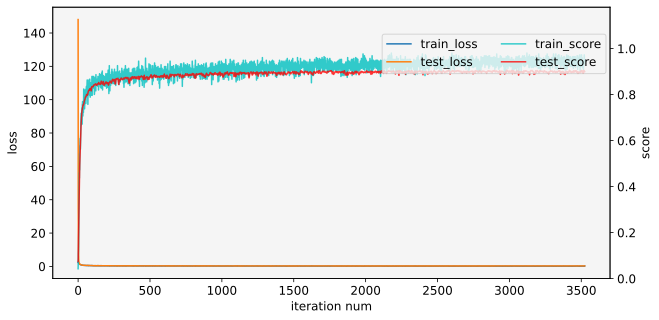

execute time is 341.272 seconds


In [12]:
# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 15,
    "model": model,
    "loss": loss,
    "data_num": len(mnist_train),
    "optimizer": optimizer,
    "draw": True, 
    "gpu": True,
    "batch_size": 256,
    "evaluate": model.score,
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=8, pin_memory=True),
    "save_fig": True,
    "save_path": "../result/BN对比试验/img/"
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8)
params["train_iter"] = train_iter
# params["test_iter"] = test_iter

# training
train_pytorch(**params)

### BN简洁实现

In [13]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class LeNet5(nn.Module):
    """带BN的LeNet简洁实现"""
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 120, 5),
            nn.BatchNorm2d(120),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            FlattenLayer(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        output = self.conv(x)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5722, train_score: 0.792, test_loss: 0.6663, test_score: 0.787

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3139, train_score: 0.881, test_loss: 0.3638, test_score: 0.869

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2767, train_score: 0.887, test_loss: 0.3556, test_score: 0.870

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2503, train_score: 0.900, test_loss: 0.3268, test_score: 0.881

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2281, train_score: 0.907, test_loss: 0.3160, test_score: 0.885

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2147, train_score: 0.914, test_loss: 0.3065, test_score: 0.889

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2044, train_score: 0.916, test_loss: 0.3113, test_score: 0.888

Epoch [8/15]
60000/60000 [>>>>>>>>

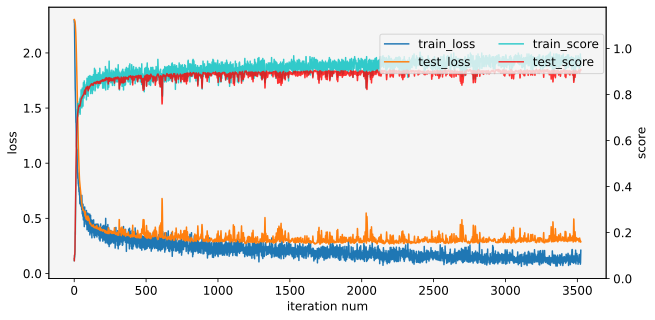

execute time is 260.336 seconds


In [14]:
# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 15,
    "model": model,
    "loss": loss,
    "data_num": len(mnist_train),
    "optimizer": optimizer,
    "draw": True, 
    "gpu": True,
    "batch_size": 256,
    "evaluate": model.score, 
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=16, pin_memory=True),
    "save_fig": True,
    "save_path": "../result/BN对比试验/img/"
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=16)
params["train_iter"] = train_iter
# params["test_iter"] = test_iter

# training
train_pytorch(**params)

Epoch [1/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 1.2935, train_score: 0.542, test_loss: 1.2959, test_score: 0.541

Epoch [2/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6100, train_score: 0.767, test_loss: 0.6325, test_score: 0.760

Epoch [3/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4981, train_score: 0.817, test_loss: 0.5254, test_score: 0.806

Epoch [4/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4464, train_score: 0.837, test_loss: 0.4758, test_score: 0.827

Epoch [5/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4092, train_score: 0.851, test_loss: 0.4409, test_score: 0.841

Epoch [6/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3842, train_score: 0.859, test_loss: 0.4193, test_score: 0.849

Epoch [7/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3598, train_score: 0.868, test_loss: 0.3965, test_score: 0.857

Epoch [8/50]
60000/60000 [>>>>>>>>

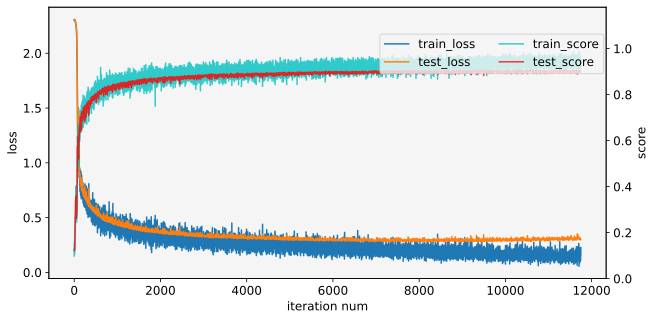

execute time is 729.101 seconds


In [6]:
# define model
model = LeNet5()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 50,
    "model": model,
    "loss": loss,
    "data_num": len(mnist_train),
    "optimizer": optimizer,
    "draw": True, 
    "gpu": True,
    "batch_size": 256,
    "evaluate": model.score, 
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=16, pin_memory=True),
    "save_fig": True,
    "save_path": "../result/BN对比试验/img/"
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=16)
params["train_iter"] = train_iter
# params["test_iter"] = test_iter

# training
train_pytorch(**params)

- 在模型训练的时候，BN利用小批量的均值和标准差，不断调整神经网络的中间输出，从而使得整个神经网络在各层中间输出的数值更加稳定
- 对全连接和卷积层做BN的方法有点不一样
- BN和Dropout一样，在训练模式和预测模式的计算结果是不一样的